In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

from modules import Net, Channel, RepeatEncoder, RepeatDecoder

In [2]:
R = 4
n_batches = 100
batch_size = 128
n_bits = 64
code_len = R*64

In [3]:
def model_accuracy(encoder, decoder, sigma):
    channel = Channel(sigma).cuda()
    all_data = (torch.rand((1000, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0
    for data in all_data:
        data = Variable(data.cuda())
        message = encoder(data)
        #message.data[message.data > 0] = 1
        #message.data[message.data < 0] = -1
        corrupted = channel(message)
        corrupted.data[corrupted.data > 0] = 1
        corrupted.data[corrupted.data < 0] = -1
        reconstruction = decoder(corrupted) 
        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
    return float(n_correct) / all_data.nelement()

R = 4
encoder = RepeatEncoder(R)
decoder = RepeatDecoder(R)
sigmas = np.array([0.5, 0.75, 1.0, 1.2, 1.5, 2.0])
repeater_err = np.array([1-model_accuracy(encoder, decoder, s) for s in sigmas])

In [18]:
mid_dim = 1024
encoder = Net(n_bits, mid_dim, code_len, 1, 'all', True).cuda()
decoder = Net(code_len, mid_dim, n_bits, 2, 'all', False).cuda()
channel = Channel(1.0).cuda()
params = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

n_stops = 0
n_stale_epochs = 0
n_epochs = 0
optimizer = optim.SGD(params, lr=10.0, momentum=0.9)
losses = []

while n_stops < 3:

    all_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0

    for data in all_data:
        optimizer.zero_grad()
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
        losses.append(loss.data[0])
        
    n_epochs += 1
    
    if losses[-n_batches] - np.std(losses[-n_batches:]) < losses[-1]:
        n_stale_epochs += 1
    else:
        n_stale_epochs = 0
        
    if n_stale_epochs > 10:
        n_stale_epochs = 0
        n_stops += 1
        optimizer.param_groups[0]['lr'] *= 0.1
        print n_epochs
    
plt.plot(losses)

print float(n_correct) / all_data.nelement()

70
82


KeyboardInterrupt: 

In [19]:
nn_err = np.array([1-model_accuracy(encoder, decoder, s) for s in sigmas])

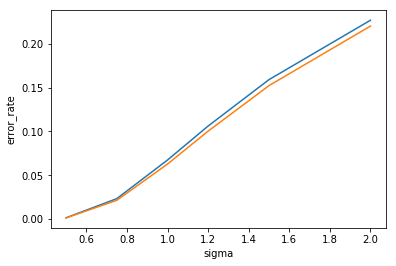

In [20]:
plt.plot(sigmas, repeater_err)
plt.plot(sigmas, nn_err)
plt.ylabel('error_rate')
plt.xlabel('sigma')

In [21]:
nn_err

array([ 0.00139575,  0.02148584,  0.06279822,  0.10030103,  0.15216638,
        0.22002722])

In [22]:
repeater_err

array([ 0.00153137,  0.023375  ,  0.06740503,  0.10610876,  0.15899988,
        0.22669556])

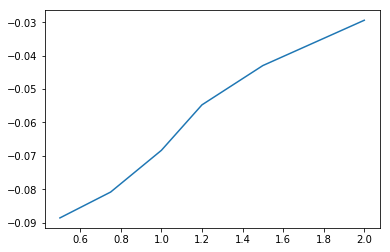

In [23]:
plt.plot(sigmas, (nn_err-repeater_err) / repeater_err)